# Monte Carlo Analysis of SPY Returns and Black–Scholes Option Pricing
## Geometric Brownian Motion, Statistical Validation, and Model Risk
Milan Fusco — Fall 2025

This notebook evaluates the adequacy of Geometric Brownian Motion (GBM) as a structural model for SPY equity returns and assesses the statistical reliability of Monte Carlo option pricing under the Black–Scholes framework.

All simulations are performed using `mcframework`, a purpose-built Monte Carlo engine featuring reproducible parallel random number generation via NumPy Philox streams.


---

## 0. Environment Setup

In [1]:
# Install mcframework if not already present
%pip install mcframework yfinance scipy matplotlib --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats

from mcframework import (
    BlackScholesSimulation,
    BlackScholesPathSimulation,
    PortfolioSimulation,
)

import logging
logging.disable(logging.CRITICAL)

plt.rcParams.update({"figure.dpi": 120, "font.size": 11})
SEED = 2025

## 1. Data and Parameter Estimation

We retrieve one year of daily SPY closing prices (Dec 2024 – Dec 2025) and compute log returns:

$$
r_t = \log\left(\frac{S_t}{S_{t-1}}\right)
$$

Under Geometric Brownian Motion (GBM), price dynamics satisfy:

$$
\frac{dS_t}{S_t} = \mu\,dt + \sigma\,dW_t
$$

The closed-form solution is:

$$
S_T = S_0 \exp\left((\mu - \tfrac{1}{2}\sigma^2)T + \sigma W_T\right)
$$

Therefore, log returns are normally distributed:

$$
\log\left(\frac{S_T}{S_0}\right)
\sim
\mathcal{N}\left((\mu - \tfrac{1}{2}\sigma^2)T,\ \sigma^2 T\right)
$$

We estimate the real-world drift $\mu$ and volatility $\sigma$ from historical log returns.


In [3]:
spy = yf.download("SPY", start="2024-12-01", end="2025-12-01", auto_adjust=True, progress=False)
prices = spy["Close"].squeeze().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

# Annualised parameters (252 trading days)
daily_mean = float(log_returns.mean())
daily_std  = float(log_returns.std())
mu    = daily_mean * 252
sigma = daily_std  * np.sqrt(252)
S0    = float(prices.iloc[-1])

print(f"Spot Price  S₀ : ${S0:.2f}")
print(f"Annual Drift μ : {mu:.4f}")
print(f"Annual Vol   σ : {sigma:.4f}")
print(f"Daily Mean     : {daily_mean:.6f}")
print(f"Daily Std Dev  : {daily_std:.6f}")
print(f"N (trading days): {len(log_returns)}")

Spot Price  S₀ : $681.38
Annual Drift μ : 0.1384
Annual Vol   σ : 0.1969
Daily Mean     : 0.000549
Daily Std Dev  : 0.012401
N (trading days): 248


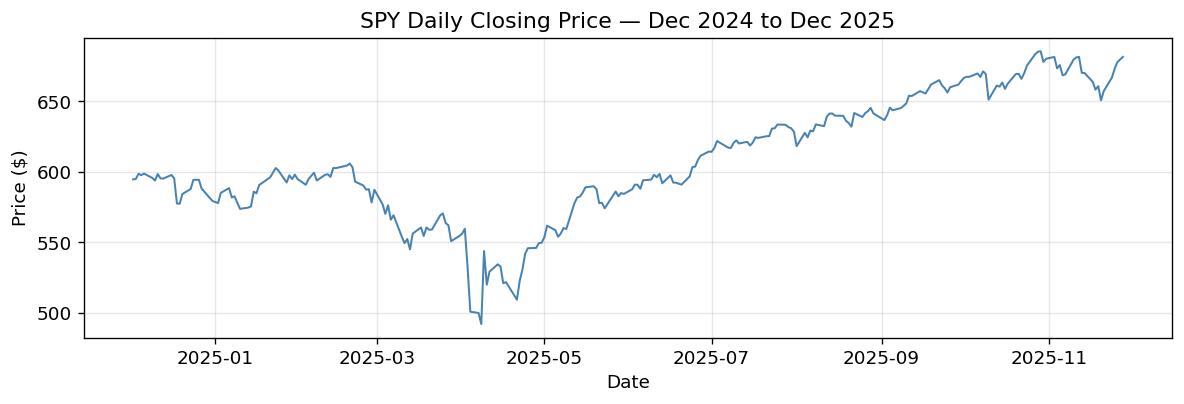

In [4]:
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(prices.index, prices.values, color="steelblue", linewidth=1.2)
ax.set_title("SPY Daily Closing Price — Dec 2024 to Dec 2025")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 2. Geometric Brownian Motion — Path Simulation

Simulations are executed using a reproducible parallel Monte Carlo engine built on:

- `numpy.random.SeedSequence`
- Independent Philox random number streams
- Deterministic stream splitting across workers
- Bitwise reproducibility regardless of parallelization (see docs for GPU caveats)

The GBM SDE and its closed-form solution:

$$\frac{dS_t}{S_t} = \mu \, dt + \sigma \, dW_t
\quad\Longrightarrow\quad
S_T = S_0 \exp\!\left[\left(\mu - \tfrac{1}{2}\sigma^2\right)T + \sigma W_T\right]$$

We use `BlackScholesPathSimulation` under the **real-world measure** (drift $= \mu$)
to visualise the fan of plausible price trajectories.

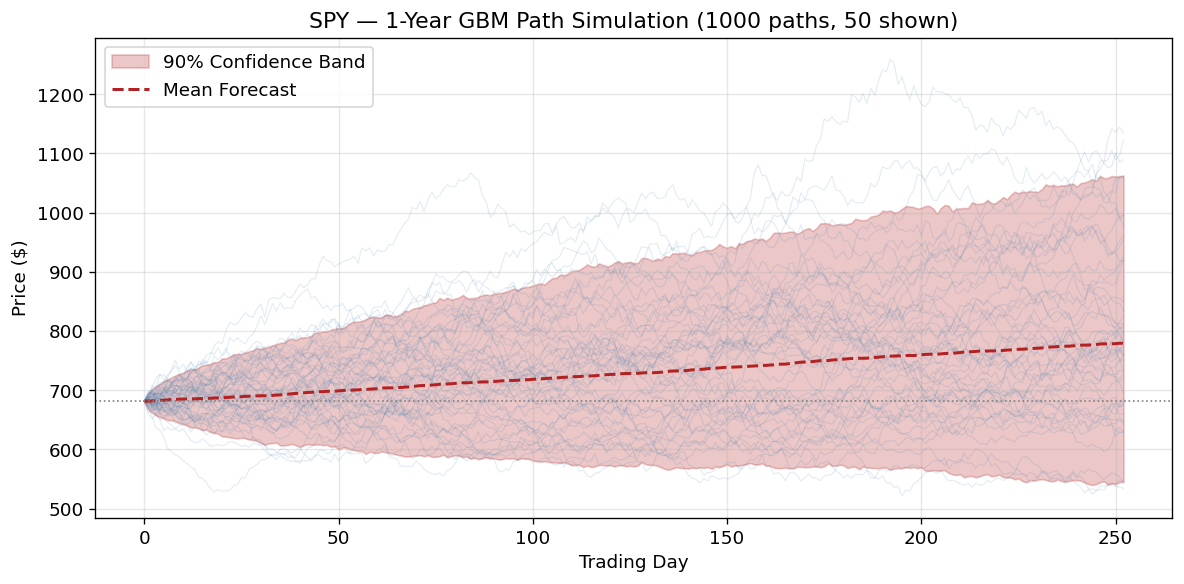

In [5]:
path_sim = BlackScholesPathSimulation()
path_sim.set_seed(SEED)

# Simulate 1-year paths under real-world drift (use mu as r for real-world measure)
paths = path_sim.simulate_paths(
    n_paths=1000,
    S0=S0,
    r=mu,        # real-world drift
    sigma=sigma,
    T=1.0,
    n_steps=252,
)

t = np.linspace(0, 252, 253)
p5  = np.percentile(paths, 5,  axis=0)
p95 = np.percentile(paths, 95, axis=0)
pmean = paths.mean(axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t, paths[:50].T, alpha=0.15, color="steelblue", linewidth=0.7)
ax.fill_between(t, p5, p95, alpha=0.25, color="firebrick", label="90% Confidence Band")
ax.plot(t, pmean, color="firebrick", linestyle="--", linewidth=1.8, label="Mean Forecast")
ax.axhline(S0, color="gray", linestyle=":", linewidth=1)
ax.set_title("SPY — 1-Year GBM Path Simulation (1000 paths, 50 shown)")
ax.set_xlabel("Trading Day")
ax.set_ylabel("Price ($)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. One-Year Forecast Distribution (Real-World Measure)

`PortfolioSimulation` models terminal wealth $V_T$ under GBM.

Terminal prices are simulated under the real-world drift $\mu$.

The resulting distribution is lognormal, producing:

- Mean > Median (right-skewed asymmetry)
- Wide tail dispersion
- Probability estimates for upward price movement

Monte Carlo estimates include standard error and percentile-based Value-at-Risk metrics.

In [6]:
port_sim = PortfolioSimulation()
port_sim.set_seed(SEED)

result = port_sim.run(
    n_simulations=100_000,
    initial_value=S0,
    annual_return=mu,
    volatility=sigma,
    years=1,
    use_gbm=True,
    parallel=True,
    percentiles=(5, 50, 95),
)

print(f"Mean terminal price  : ${result.mean:.2f}")
print(f"Median               : ${result.percentiles[50]:.2f}")
print(f"5th percentile  (VaR): ${result.percentiles[5]:.2f}")
print(f"95th percentile      : ${result.percentiles[95]:.2f}")
prob_profit = np.mean(result.results > S0)
print(f"P(S_T > S₀)          : {prob_profit:.2f}")

Mean terminal price  : $782.16
Median               : $767.26
5th percentile  (VaR): $555.33
95th percentile      : $1058.55
P(S_T > S₀)          : 0.73


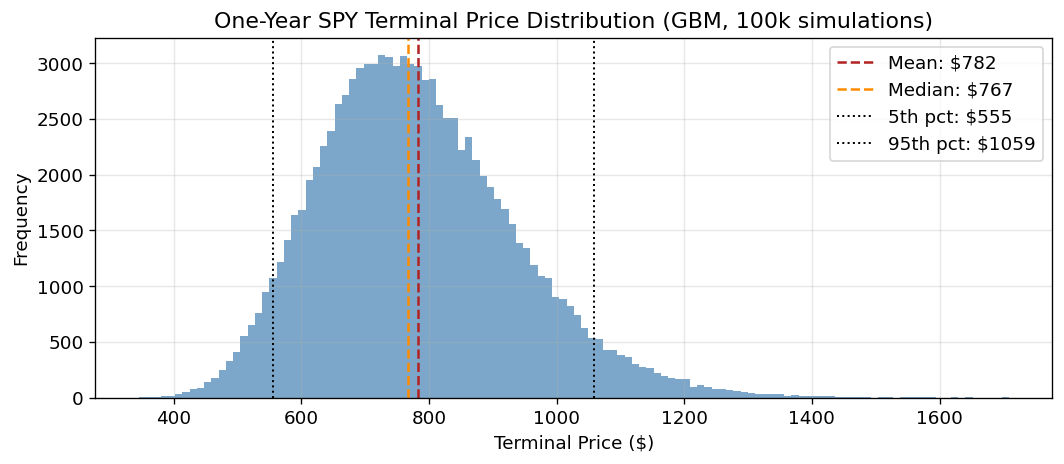

In [7]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(
    result.results, bins=120, color="steelblue",
    alpha=0.7, edgecolor="none")
ax.axvline(
    result.mean,            color="firebrick",  linestyle="--",
    linewidth=1.5, label=f"Mean: ${result.mean:.0f}")
ax.axvline(
    result.percentiles[50], color="darkorange", linestyle="--",
    linewidth=1.5, label=f"Median: ${result.percentiles[50]:.0f}")
ax.axvline(
    result.percentiles[5],  color="black",      linestyle=":",
    linewidth=1.2, label=f"5th pct: ${result.percentiles[5]:.0f}")
ax.axvline(
    result.percentiles[95], color="black",     linestyle=":",
    linewidth=1.2, label=f"95th pct: ${result.percentiles[95]:.0f}")
ax.set_title("One-Year SPY Terminal Price Distribution (GBM, 100k simulations)")
ax.set_xlabel("Terminal Price ($)")
ax.set_ylabel("Frequency")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. Empirical Validation — Distributional Comparison

Although GBM matches the first two moments (mean and variance) by construction, its structural assumptions imply:

- Zero skewness
- Zero excess kurtosis
- Normally distributed log returns

We compare historical SPY log returns against simulated GBM returns.

In [8]:
lr = log_returns.values.flatten()
print("=== Historical SPY Log Returns ===")
print(f"  Mean     : {lr.mean():.6f}")
print(f"  Std Dev  : {lr.std():.6f}")
print(f"  Skewness : {float(stats.skew(lr)):.3f}")
print(f"  Ex. Kurt : {float(stats.kurtosis(lr)):.3f}")

# Synthetic GBM returns to compare
rng = np.random.default_rng(SEED)
dt  = 1 / 252
gbm_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rng.normal(size=100_000)

print("\n=== GBM Simulated Log Returns ===")
print(f"  Mean     : {gbm_returns.mean():.6f}")
print(f"  Std Dev  : {gbm_returns.std():.6f}")
print(f"  Skewness : {stats.skew(gbm_returns):.3f}")
print(f"  Ex. Kurt : {stats.kurtosis(gbm_returns):.3f}")

=== Historical SPY Log Returns ===
  Mean     : 0.000549
  Std Dev  : 0.012376
  Skewness : 1.014
  Ex. Kurt : 19.182

=== GBM Simulated Log Returns ===
  Mean     : 0.000393
  Std Dev  : 0.012417
  Skewness : -0.009
  Ex. Kurt : 0.004


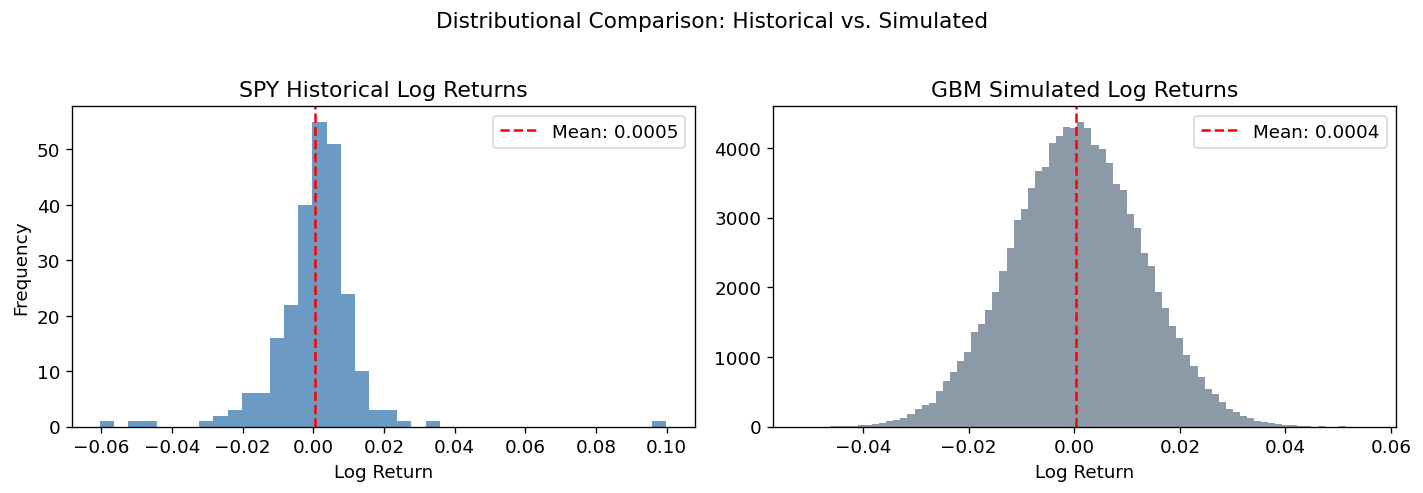

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes[0].hist(lr, bins=40, color="steelblue", edgecolor="none", alpha=0.8)
axes[0].axvline(lr.mean(), color="red", linestyle="--", linewidth=1.5, label=f"Mean: {lr.mean():.4f}")
axes[0].set_title("SPY Historical Log Returns")
axes[0].set_xlabel("Log Return")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist(gbm_returns, bins=80, color="slategray", edgecolor="none", alpha=0.8)
axes[1].axvline(gbm_returns.mean(), color="red", linestyle="--", linewidth=1.5, label=f"Mean: {gbm_returns.mean():.4f}")
axes[1].set_title("GBM Simulated Log Returns")
axes[1].set_xlabel("Log Return")
axes[1].legend()

plt.suptitle("Distributional Comparison: Historical vs. Simulated", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 5. Hypothesis Testing

### 5a. Equality of Means — Two-sample z-test

Fail to reject equality of means, consistent with GBM's construction to match the first moment of historical returns.

In [10]:
# 5a: Two-sample z-test (large n -> normal approx)
n1, n2    = len(lr), len(gbm_returns)
se_diff   = np.sqrt(lr.var()/n1 + gbm_returns.var()/n2)
z_stat    = (lr.mean() - gbm_returns.mean()) / se_diff
p_mean    = 2 * (1 - stats.norm.cdf(abs(z_stat)))
print(f"Mean Test:   z = {z_stat:.3f},  p = {p_mean:.3f}")

Mean Test:   z = 0.198,  p = 0.843


### 5b. Equality of Variances — Levene's test
Reject equality of variances, consistent with the wider tails observed in historical returns.


In [11]:
# 5b: Levene's test for equality of variances
lev_stat, p_var = stats.levene(lr, gbm_returns)
print(f"Var  Test:   W = {float(lev_stat):.3f},  p = {float(p_var):.3f}")

Var  Test:   W = 23.826,  p = 0.000


### 5c. Normality of Historical Returns — Shapiro-Wilk
$p < 10^{-6} \Rightarrow$ reject normality of historical returns, consistent with fat tails observed in the histogram and excess kurtosis.

In [12]:
# 5c: Normality (Shapiro-Wilk on historical returns)
sw_stat, p_norm = stats.shapiro(lr)
print(f"Normality:   W = {sw_stat:.4f}, p = {p_norm:.2e}")

Normality:   W = 0.8014, p = 4.45e-17


**Conclusion:**
Although the first moment is statistically consistent with calibration, historical returns strongly reject normality and exhibit variance behavior inconsistent with GBM.

The failure arises from higher-order moment structure, not from Monte Carlo noise.

$$
\quad
$$

$$
\quad
$$

$$
\quad
$$

$$
\quad
$$

 ## 6. Risk-Neutral Option Pricing

Under the risk-neutral measure $\mathbb{Q}$:

$$
\frac{dS_t}{S_t} = r\,dt + \sigma\,dW_t^{\mathbb{Q}}
$$

Under $\mathbb{Q}$, discounted asset prices are martingales.
The real-world drift $\mu$ is replaced by the risk-free rate $r$ to ensure no-arbitrage pricing.

Closed-form Black–Scholes solution:

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

$$
d_1 = \frac{\ln(S_0/K) + \left(r + \tfrac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$



In [13]:
# Risk-free rate (approx. 1-year T-bill rate, end of 2024)
R_F = 0.0525
K   = S0          # ATM strike
T   = 1.0          # 1 year

bs = BlackScholesSimulation()
bs.set_seed(SEED)

# European Call
call_result = bs.run(
    n_simulations=100_000,
    S0=S0, K=K, T=T, r=R_F, sigma=sigma,
    option_type="call",
    exercise_type="european",
    parallel=True,
)

# European Put
put_result = bs.run(
    n_simulations=100_000,
    S0=S0, K=K, T=T, r=R_F, sigma=sigma,
    option_type="put",
    exercise_type="european",
    parallel=True,
)

call_ci = call_result.stats["ci_mean"]
put_ci  = put_result.stats["ci_mean"]

print(f"European Call  Ĉ = ${call_result.mean:.2f}")
print(f"  SE = {call_result.stats['se']:.4f}   95% CI: [${call_ci['low']:.2f}, ${call_ci['high']:.2f}]")
print()
print(f"European Put   P̂ = ${put_result.mean:.2f}")
print(f"  SE = {put_result.stats['se']:.4f}   95% CI: [${put_ci['low']:.2f},  ${put_ci['high']:.2f}]")

European Call  Ĉ = $70.94
  SE = 0.3119   95% CI: [$70.33, $71.55]

European Put   P̂ = $36.24
  SE = 0.1813   95% CI: [$35.88,  $36.60]


In [14]:
# Put-Call Parity check: C - P = S0 - K * exp(-r * T)
pcp_lhs = call_result.mean - put_result.mean
pcp_rhs = S0 - K * np.exp(-R_F * T)
print(f"Put-Call Parity check:")
print(f"  C - P = {pcp_lhs:.4f}")
print(f"  S₀ - K·e^(-rT) = {pcp_rhs:.4f}")
print(f"  Residual: {abs(pcp_lhs - pcp_rhs):.4f}  ({'passes' if abs(pcp_lhs - pcp_rhs) < 1.0 else 'fails'})")

Put-Call Parity check:
  C - P = 34.6985
  S₀ - K·e^(-rT) = 34.8495
  Residual: 0.1510  (passes)


## 7. Greeks via Finite Differences

Option sensitivities are estimated using central finite differences.

Each Greek requires two simulations per parameter perturbation.

Computed sensitivities include:

- Delta: $\partial V/\partial S$
- Gamma: $\partial^2 V/\partial S^2$
- Vega: $\partial V/\partial \sigma$
- Theta: $\partial V/\partial T$
- Rho: $\partial V/\partial r$

Finite-difference estimates introduce additional Monte Carlo noise, but confidence intervals remain stable relative to price level.

In [15]:
greeks = bs.calculate_greeks(
    n_simulations=50_000,
    S0=S0, K=K, T=T, r=R_F, sigma=sigma,
    option_type="call",
    exercise_type="european",
    parallel=True,
)

print("European Call Greeks (ATM)")
print(f"  Delta (dV/dS)              : {greeks['delta']:.4f}")
print(f"  Gamma (d²V/dS²)            : {greeks['gamma']:.6f}")
print(f"  Vega  (dV/dσ, per 1% move) : {greeks['vega']:.4f}")
print(f"  Theta (daily decay)        : {greeks['theta']:.4f}")
print(f"  Rho   (dV/dr, per 1% move) : {greeks['rho']:.4f}")

European Call Greeks (ATM)
  Delta (dV/dS)              : 0.6396
  Gamma (d²V/dS²)            : 0.002763
  Vega  (dV/dσ, per 1% move) : 2.5153
  Theta (daily decay)        : -0.1204
  Rho   (dV/dr, per 1% move) : 3.6498


## 8. Conclusions

### Key Findings

1. GBM reproduces empirical mean and variance by construction.
2. Historical SPY returns exhibit statistically significant skewness and extreme excess kurtosis inconsistent with GBM assumptions.
3. Monte Carlo pricing under the risk-neutral measure is numerically stable; sampling error is small relative to price magnitude.
4. Put–call parity holds within Monte Carlo tolerance, confirming internal consistency.
5. Structural model error dominates Monte Carlo sampling error.

### Implication

Black–Scholes provides a coherent no-arbitrage pricing framework and GBM reproduces first-order and second-order moments by calibration.

However, its underlying GBM assumption inadequately captures real-world return dynamics. Significant positive skewness and extreme excess kurtosis in historical returns indicate heavy tails inconsistent with the Gaussian assumption.

## Structural vs Sampling Error

Monte Carlo standard error decreases at rate $1/\sqrt{N}$.

However, no increase in simulation count can correct structural misspecification in the underlying return model.

Empirical skewness and heavy tails indicate that model risk, not Monte Carlo variance, is the dominant source of pricing error under GBM.

### Future Directions

- Heston stochastic volatility
- GARCH dynamics
- Jump-diffusion (Merton)
- Calibration to implied volatility surface
- Out-of-sample validation

---
**References**  
Black, F. & Scholes, M. (1973). *The pricing of options and corporate liabilities.*  
Fusco, M. (2026). [mcFramework](https://github.com/milanfusco/mcFramework).  
NumPy, SciPy, Matplotlib, yfinance.